# การสร้าง Model สำหรับ Text Classification โดยใช้ Bag-of-word Feature กับ Standard Feedforward Neural Network

In [78]:
pip install thai_tokenizer

In [79]:
import csv
import numpy as np
import deepcut
from keras.models import Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Embedding, Dropout, Flatten, concatenate
from tensorflow.keras.utils import to_categorical, set_random_seed
import matplotlib.pyplot as plt
from random import shuffle

set_random_seed(99)

**Read raw data form input.txt and ans.txt**

In [80]:
with open('input.txt', 'r', encoding='utf-8-sig') as input_file:
    input_data = [line.strip().split('::')[1] for line in input_file]

with open('ans.txt', 'r', encoding='utf-8-sig') as ans_file:
    ans_data = [line.strip().split('::')[1] for line in ans_file]
    

# Create a list to store the combined data
combined_data = []

for input_line, ans_line in zip(input_data, ans_data):
    combined_line = [ans_line, input_line]
    combined_data.append(combined_line)

# Shuffle the input data
shuffle(combined_data)
# Print the result as a list of lists
for combined_line in combined_data:
    print(combined_line)

['T,T', 'ตานี้ก็เข้าเกมไม่ได้ ตาหน้าก็ไม่ได้เล่น']
['P,E', 'ตาของแม่สายตายาว']
['P', 'นางสาวมุทิตาได้รางวัลจากตาเพราะเรียนได้ที่หนึ่ง']
['T', 'ไม่มีตาไหนที่เธอไม่โยนเกม']
['E,E', 'หมอตาตรวจดวงตาของฉัน']
['E', 'การนอนตะแคงเล่นโทรศัพท์มีโอกาสทำให้สายตาเอียง']
['P,P', 'เธอดูสิ ตาคนนี้นี่แหละที่ถูกทิ้งไปตอนเด็ก ทำไมตาคนนี้ถึงมีชีวิตที่ดีขึ้นขนาดนี้นะ']
['P,E', 'ตาแก่สองคนกำลังนั่งจ้องตากัน']
['E', "vel'koz เป็นสัตว์ประหลาดจาก Void ที่มีดวงตาขนาดใหญ่อยู่ตรงกลาง"]
['E', 'ตาของเขาเป็นสีน้ำตาล']
['P,T', 'คุณตาและคุณยายตอนนี้แก่มากแล้วเลยทำให้ดวงตาฝ้าฟาง']
['E', 'สายตาเธอหลอกฉันไม่ได้']
['E', 'ฉันจึงเลิกใช้ที่ปัดขนตา']
['T,T', 'ตานี้บอด ตาหน้าเอาใหม่']
['T', 'ตาที่เธอเล่นได้ดีมีอยู่จริงไหม']
['P,T', 'ตาเอ้ย วันนี้ตาฉันนวดเอวให้นะ']
['T,T,T', 'ตานี้จะเป็นรอบสุดท้ายหรือตาหน้าจะเป็นตาสุดท้ายกันแน่นะ']
['E', 'ดวงตาเห็นธรรมเหนือวัตถุ เป็นผลงานที่สื่อให้เห็นถึงจิตกับวัตถุ']
['P,P', 'เอามานี่ เขาทำกันแบบนี้ เธอนี่มันไม่รู้ตาสีตาสา']
['E', 'หมอที่รักษาเกี่ยวกับตาคือหมอเฉพาะทาง']
['P', 'ตาชอบสีน้ำตาล']


**Create dataset. Extract labels and sentences.**

In [81]:
labels = [d[0] for d in combined_data]
sentences = [d[1] for d in combined_data]

print(labels)
print(sentences)

['T,T', 'P,E', 'P', 'T', 'E,E', 'E', 'P,P', 'P,E', 'E', 'E', 'P,T', 'E', 'E', 'T,T', 'T', 'P,T', 'T,T,T', 'E', 'P,P', 'E', 'P', 'E', 'P,P', 'E', 'E', 'E,E', 'E', 'E', 'E', 'E', 'E', 'E', 'T', 'E', 'P', 'P', 'P,E', 'T', 'P', 'E', 'E', 'P', 'E,E', 'E,P', 'P', 'P', 'P', 'P,E,P', 'P,P', 'E', 'P,E', 'P,E', 'T,E,P', 'P', 'E,E', 'E,E', 'P', 'E', 'E', 'E', 'P', 'T,P,E', 'T', 'P,P,P', 'P', 'E', 'P', 'T', 'E,E,E', 'P,T', 'E,P', 'P', 'P', 'E', 'E', 'P,E', 'P', 'T,T', 'E', 'P,P', 'E', 'T', 'E', 'T,E', 'T,P', 'P', 'E', 'P', 'E', 'P,P', 'T,T', 'T', 'E', 'E', 'E', 'E', 'P', 'E,P', 'P,P', 'E', 'P', 'P,P', 'T', 'E,E', 'E,E', 'E', 'E,E', 'E,E', 'P,P,P', 'P,T', 'E', 'P', 'T', 'E,E', 'P', 'E', 'E', 'E', 'E', 'E', 'E', 'T', 'T', 'P,P', 'E', 'P', 'P', 'E,E', 'P', 'E', 'T,P', 'P,P', 'P', 'T,E', 'P,E', 'E', 'E', 'E', 'E', 'T', 'T,P', 'P,E', 'T', 'T', 'E', 'T', 'T', 'P', 'E,T', 'P', 'P', 'T', 'P', 'T', 'E', 'P', 'E', 'P', 'E', 'P,E', 'T', 'E', 'E,P', 'P', 'E', 'T', 'P', 'P,P', 'E,P,P', 'P', 'P,E', 'E', 'P', 'E

**Tokenize each sentence into a list of words.**

In [82]:
from pythainlp.tokenize import word_tokenize
from thai_tokenizer import Tokenizer

tokenizer = Tokenizer()

tokenized_sentences = [
    [word for word in word_tokenize(sentence, engine="newmm", keep_whitespace=False)]
    for sentence in sentences
]

for sentence_tokens in tokenized_sentences:
    print(sentence_tokens)


['ตา', 'นี้', 'ก็', 'เข้า', 'เกม', 'ไม่', 'ได้', 'ตา', 'หน้า', 'ก็', 'ไม่', 'ได้', 'เล่น']
['ตา', 'ของ', 'แม่', 'สายตายาว']
['นางสาว', 'มุทิตา', 'ได้', 'รางวัล', 'จาก', 'ตา', 'เพราะ', 'เรียน', 'ได้', 'ที่หนึ่ง']
['ไม่', 'มี', 'ตา', 'ไหน', 'ที่', 'เธอ', 'ไม่', 'โยน', 'เกม']
['หมอ', 'ตา', 'ตรวจ', 'ดวงตา', 'ของ', 'ฉัน']
['การ', 'นอนตะแคง', 'เล่น', 'โทรศัพท์', 'มีโอกาส', 'ทำให้', 'สายตาเอียง']
['เธอ', 'ดู', 'สิ', 'ตา', 'คน', 'นี้', 'นี่แหละ', 'ที่', 'ถูก', 'ทิ้ง', 'ไป', 'ตอน', 'เด็ก', 'ทำไม', 'ตา', 'คน', 'นี้', 'ถึง', 'มีชีวิต', 'ที่', 'ดีขึ้น', 'ขนาด', 'นี้', 'นะ']
['ตาแก่', 'สอง', 'คน', 'กำลัง', 'นั่ง', 'จ้อง', 'ตา', 'กัน']
['vel', "'", 'koz', 'เป็น', 'สัตว์ประหลาด', 'จาก', 'Void', 'ที่', 'มี', 'ดวงตา', 'ขนาดใหญ่', 'อยู่', 'ตรงกลาง']
['ตา', 'ของ', 'เขา', 'เป็น', 'สีน้ำตาล']
['คุณตา', 'และ', 'คุณยาย', 'ตอนนี้', 'แก่', 'มาก', 'แล้ว', 'เลย', 'ทำให้', 'ดวงตา', 'ฝ้าฟาง']
['สายตา', 'เธอ', 'หลอก', 'ฉัน', 'ไม่', 'ได้']
['ฉัน', 'จึง', 'เลิกใช้', 'ที่', 'ปัด', 'ขน', 'ตา']
['ตา', 'นี้', 'บอด', 'ตา'

**Find all possible words (vocab).**

In [83]:
vocab = set([w for s in tokenized_sentences for w in s])
print('Vocab size = '+str(len(vocab)))
print(vocab)

Vocab size = 4608
{'มหาวิทยาลัย', 'ขี่', 'รอบตัว', 'ONE', 'หัก', 'แย่งตำแหน่ง', 'ใช้ชีวิต', 'ปวดหลัง', 'ลงคอ', 'ที่พึ่ง', 'หว่า', 'แป', 'คิส', 'หลบสายตา', 'ฮวก', 'ประมาณ', 'ๆลง', 'หลบ', 'บุก', 'ไอติม', 'จบเกม', 'ลึก', '15', 'พบ', 'เด็กวัด', 'ดุร้าย', 'แนะนำ', 'เสี่ยว', 'แว่นสายตา', 'เพียงลำพัง', 'แล้วแต่', 'ย้อนกลับ', 'เรียว', 'อาการหนัก', 'ดูเถอะ', 'อัน', 'ขอโทษ', 'อ้วก', 'Mcdonald', 'นางสาว', 'กรอง', 'นุ่ม', 'อุ้ย', 'ไผ', 'นักบินอวกาศ', 'ยอน', 'วว', 'แตงกวา', 'ขาว', 'เมือง', 'ทาน', 'พื้น', 'บอกลา', 'ฝาย', 'ผลเสียหาย', 'กอง', 'เด้ง', 'เดียว', 'ไซ', 'คนละ', 'เทคโนโลยี', 'เนื่องจาก', 'มีทาง', 'แสดง', 'น่า', 'ม่าน', 'อี้', 'เทิร์น', 'เอิ่ม', 'สายฟ้า', 'ตาก', 'หิวโซ', 'พันลำ', 'ธันวา', 'กีฬา', 'ราม', 'พูดถึง', 'ปั่น', 'แข', 'สูบบุหรี่', 'โรคจิต', 'พันตา', 'โนน', 'ไหม', 'ตลอดเวลา', 'หม่น', 'ขี้แพ้ชวนตี', '"', 'ไฟ', 'ส้มตำ', 'ทะลุ', 'เม', 'ตัวตน', 'หมดตัว', 'ผู้หญิง', 'ค่าใช้จ่าย', 'เปีบ', 'โวลต์', 'เกาะ', 'ก่อนที่จะ', 'สาม', 'แมวมอง', 'สแกน', 'ส่วนหนึ่ง', 'จง', 'สมาชิก', 'ซา', 'ปาฏิหาริย์'

In [84]:
print(labels)

labels = [j.split(',') for j in labels]
for k in range(len(labels)):
    if '' in labels[k]:
        labels[k].remove('')
for l in range(len(labels)):
    for m in range(len(labels[l])):
        if labels[l][m]=='E'or labels[l][m]=='e':       #Eyes Labels 0
            labels[l][m]=0
        elif labels[l][m]=='P'or labels[l][m]=='p':     #Grandfather or Name Labels1
            labels[l][m]=1
        elif labels[l][m]=='T'or labels[l][m]=='t':     #Turn Labels 2
            labels[l][m]=2

print(labels)

['T,T', 'P,E', 'P', 'T', 'E,E', 'E', 'P,P', 'P,E', 'E', 'E', 'P,T', 'E', 'E', 'T,T', 'T', 'P,T', 'T,T,T', 'E', 'P,P', 'E', 'P', 'E', 'P,P', 'E', 'E', 'E,E', 'E', 'E', 'E', 'E', 'E', 'E', 'T', 'E', 'P', 'P', 'P,E', 'T', 'P', 'E', 'E', 'P', 'E,E', 'E,P', 'P', 'P', 'P', 'P,E,P', 'P,P', 'E', 'P,E', 'P,E', 'T,E,P', 'P', 'E,E', 'E,E', 'P', 'E', 'E', 'E', 'P', 'T,P,E', 'T', 'P,P,P', 'P', 'E', 'P', 'T', 'E,E,E', 'P,T', 'E,P', 'P', 'P', 'E', 'E', 'P,E', 'P', 'T,T', 'E', 'P,P', 'E', 'T', 'E', 'T,E', 'T,P', 'P', 'E', 'P', 'E', 'P,P', 'T,T', 'T', 'E', 'E', 'E', 'E', 'P', 'E,P', 'P,P', 'E', 'P', 'P,P', 'T', 'E,E', 'E,E', 'E', 'E,E', 'E,E', 'P,P,P', 'P,T', 'E', 'P', 'T', 'E,E', 'P', 'E', 'E', 'E', 'E', 'E', 'E', 'T', 'T', 'P,P', 'E', 'P', 'P', 'E,E', 'P', 'E', 'T,P', 'P,P', 'P', 'T,E', 'P,E', 'E', 'E', 'E', 'E', 'T', 'T,P', 'P,E', 'T', 'T', 'E', 'T', 'T', 'P', 'E,T', 'P', 'P', 'T', 'P', 'T', 'E', 'P', 'E', 'P', 'E', 'P,E', 'T', 'E', 'E,P', 'P', 'E', 'T', 'P', 'P,P', 'E,P,P', 'P', 'P,E', 'E', 'P', 'E

In [85]:
# Word Vector train
max_sentence_length = max([len(s) for s in words])
word_vector_length = 300
from pythainlp import word_vector
wv = word_vector.WordVector(model_name="thai2fit_wv").get_model() # load thai2fit_wv from pythainlp

word_vectorstrain = np.zeros(
    (3855, max_sentence_length, word_vector_length)
)
sample_count = 0
for s in tokenized_sentences[:3855]:
    word_count = 0
    for w in s:
        try:
            word_vectorstrain[
                sample_count, max_sentence_length - word_count - 1, :
            ] = wv[w]
            word_count = word_count + 1
        except:
            pass
    sample_count = sample_count + 1

y_train = labels[:3855]
print(word_vectorstrain)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-3.81469987e-02 -4.91578013e-01  7.27770030e-02 ...  9.50586021e-01
   -2.90252000e-01 -9.40532982e-01]
  [-1.61553994e-01 -6.06257975e-01  7.39239976e-02 ...  1.16546905e+00
    2.68029004e-01  1.52985007e-01]
  [ 2.60852009e-01 -2.05634996e-01  8.95159990e-02 ... -2.98207998e-01
   -3.80499996e-02  3.44029009e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-1.15291998e-01  2.5

**Extract bag-of-word feature for each sentence**

In [86]:
#Word Vector Test
word_vector_length = 300
from pythainlp import word_vector
wv = word_vector.WordVector(model_name="thai2fit_wv").get_model() # load thai2fit_wv from pythainlp

#0-4000 for train
word_vectorstest = np.zeros((963,max_sentence_length,word_vector_length))
sample_count = 0
for s in tokenized_sentences[3855:]:
    word_count = 0
    for w in s:
        try:
            word_vectorstest[sample_count,max_sentence_length-word_count-1,:] = wv[w]
            word_count = word_count+1
        except:
            pass
    sample_count = sample_count+1

y_test =labels[3855:]
print(word_vectorstest)

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [-0.189531   -0.236876    0.303058   ... -0.024357   -0.046025
   -0.063252  ]
  [ 0.26085201 -0.205635    0.089516   ... -0.298208   -0.03805
    0.34402901]
  [-0.40430501 -0.121737   -0.098051   ...  0.144035   -0.19818
    0.29899299]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [-0.042567   -0.40059099  0.079301   ...  0.16655301 -0.19241001
   -0.027764  ]
  [-0.189711   -0.17477401  0.171124   ...  0.006287   -0.707434
   -0.070234  ]
  [ 0.26085201 -0.205635    0.089516   ... -0.298208   -0.03805
    0.34402901]]

 [[ 0.          0.          0.         ...  0.   

In [87]:
#Y_train to catagorical
y1,y2,y3 = [],[],[]
for i in y_train:
  if len(i)==3:
    y1.append(i[0])
    y2.append(i[1])
    y3.append(i[2])
  elif len(i)==2:
    y1.append(i[0])
    y2.append(i[1])
    y3.append(3)
  elif len(i)==1:
    y1.append(i[0])
    y2.append(3)
    y3.append(3)
y1,y2,y3 = to_categorical(y1,num_classes=4),to_categorical(y2),to_categorical(y3)
y_train_last = [y1[:,:], y2[:,:],y3[:,:]]

print(y_train_last[0].shape,y_train_last[1].shape,y_train_last[2].shape)

#Y_test 
y1,y2,y3 = [],[],[]
for i in y_test:
  if len(i)==3:
    y1.append(i[0])
    y2.append(i[1])
    y3.append(i[2])
  elif len(i)==2:
    y1.append(i[0])
    y2.append(i[1])
    y3.append(3)
  elif len(i)==1:
    y1.append(i[0])
    y2.append(3)
    y3.append(3)
y1,y2,y3 = to_categorical(y1,num_classes=4),to_categorical(y2),to_categorical(y3)
y_test_last = [y1[:,:], y2[:,:],y3[:,:]]
print(len(y_test_last[0]),len(y_test_last[1]),len(y_test_last[2]))
print(max_sentence_length,word_vector_length)

(3855, 4) (3855, 4) (3855, 4)
963 963 963
34 300


In [88]:
# Model
inputLayer = Input(
    shape=(
        max_sentence_length,
        word_vector_length,
    )
)
# rnn1 = LSTM(100, activation='tanh',return_sequences=True)(inputLayer)
# rnn1 = Embedding(word_vector_length, 128)(inputLayer)
rnn1 = Bidirectional(LSTM(64, return_sequences=True))(inputLayer)
rnn1 = Bidirectional(LSTM(64))(rnn1)
# rnn1 = Dropout(0.5)(rnn1)
# rnn1 = LSTM(10,activation='tanh')(rnn1)
# rnn1 = Dropout(0.2)(rnn1)
h2 = Dense(10, activation="tanh")(rnn1)
output1 = Dense(4, activation="softmax", name="output1")(h2)  # for 3 classes
output2 = Dense(4, activation="softmax", name="output2")(h2)  # for 3 classes
output3 = Dense(4, activation="softmax", name="output3")(h2)  # for 3 classes
model = Model(inputs=inputLayer, outputs=[output1, output2, output3])

losses = {
    "output1": "categorical_crossentropy",
    "output2": "categorical_crossentropy",
    "output3": "categorical_crossentropy",
}

lossWeights = {"output1": 1.0, "output2": 1.0, "output3": 1.0}

multiMetrics = {
    "output1": ["accuracy"],
    "output2": ["accuracy"],
    "output3": ["accuracy"],
}

model.compile(
    optimizer="adam", loss=losses, loss_weights=lossWeights, metrics=multiMetrics
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34, 300)]    0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 34, 128)     186880      ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 bidirectional_11 (Bidirectiona  (None, 128)         98816       ['bidirectional_10[0][0]']       
 l)                                                                                               
                                                                                            

In [89]:
history = model.fit(word_vectorstrain, y_train_last, epochs=300, batch_size=50, validation_split = 0.2)
model.save('model_102.h5')

Epoch 1/300
62/62 [==============================] - 17s 153ms/step - loss: 2.6660 - output1_loss: 1.0819 - output2_loss: 1.0598 - output3_loss: 0.5243 - output1_accuracy: 0.4601 - output2_accuracy: 0.6310 - output3_accuracy: 0.8992 - val_loss: 2.2548 - val_output1_loss: 0.8852 - val_output2_loss: 0.9482 - val_output3_loss: 0.4214 - val_output1_accuracy: 0.5953 - val_output2_accuracy: 0.6667 - val_output3_accuracy: 0.9092
Epoch 2/300
62/62 [==============================] - 6s 97ms/step - loss: 2.1896 - output1_loss: 0.8065 - output2_loss: 0.9799 - output3_loss: 0.4032 - output1_accuracy: 0.6693 - output2_accuracy: 0.6391 - output3_accuracy: 0.9128 - val_loss: 2.0499 - val_output1_loss: 0.7291 - val_output2_loss: 0.9368 - val_output3_loss: 0.3841 - val_output1_accuracy: 0.7095 - val_output2_accuracy: 0.6667 - val_output3_accuracy: 0.9092
Epoch 3/300
62/62 [==============================] - 6s 96ms/step - loss: 2.0017 - output1_loss: 0.6903 - output2_loss: 0.9360 - output3_loss: 0.3754 

In [90]:
print(word_vectorstest)

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [-0.189531   -0.236876    0.303058   ... -0.024357   -0.046025
   -0.063252  ]
  [ 0.26085201 -0.205635    0.089516   ... -0.298208   -0.03805
    0.34402901]
  [-0.40430501 -0.121737   -0.098051   ...  0.144035   -0.19818
    0.29899299]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [-0.042567   -0.40059099  0.079301   ...  0.16655301 -0.19241001
   -0.027764  ]
  [-0.189711   -0.17477401  0.171124   ...  0.006287   -0.707434
   -0.070234  ]
  [ 0.26085201 -0.205635    0.089516   ... -0.298208   -0.03805
    0.34402901]]

 [[ 0.          0.          0.         ...  0.   

In [91]:
print(labels[3855:])

[[2, 1, 1], [1, 0, 0], [1, 0, 1], [0], [0], [0], [1, 0], [1], [2], [0], [0], [2], [1, 0], [2], [1], [1], [1], [2], [2], [0], [1, 1], [2], [2, 2], [0], [2], [0], [0, 0, 0], [0], [2], [2], [2, 2, 1], [0, 0, 0], [0], [0, 0, 0], [0, 0], [0], [0], [1], [1], [2], [2], [0], [1], [0], [1, 1], [2], [1], [1], [1], [0], [1], [1], [1], [1], [2, 2], [1], [0], [1], [1], [2, 1, 2], [2], [0], [1, 2, 2], [2, 2], [0, 0], [1], [2, 0], [0], [0, 0], [1, 0, 1], [0], [1, 0], [0], [0], [1], [1], [2, 2], [1], [1], [1], [1], [1], [0], [2, 1], [0], [1], [0, 0], [1], [0], [1], [0], [0, 0], [0], [2], [2, 2], [0], [1, 0], [0], [0], [1, 1, 1], [0, 0], [0], [2], [2], [2, 2], [1, 0], [0], [0, 1, 1], [1], [1, 1], [0], [2, 2], [1], [0], [0], [0], [1, 0], [0], [0], [0], [1], [0, 2], [1, 0, 1], [0, 0], [0, 1], [1], [1, 1], [0], [2, 2], [0], [1], [2], [1, 1], [0], [1], [1], [1], [1, 0], [1], [0], [1], [1], [2, 1, 1], [1], [2, 2], [0], [1], [1, 0], [1, 0], [1], [1], [1, 1, 2], [1, 0], [0], [1], [1], [1], [0], [0], [1, 1, 0]

31/31 [==============================] - 3s 38ms/step
Test loss: 4.249754905700684
Test accuracy: 160.0266933441162


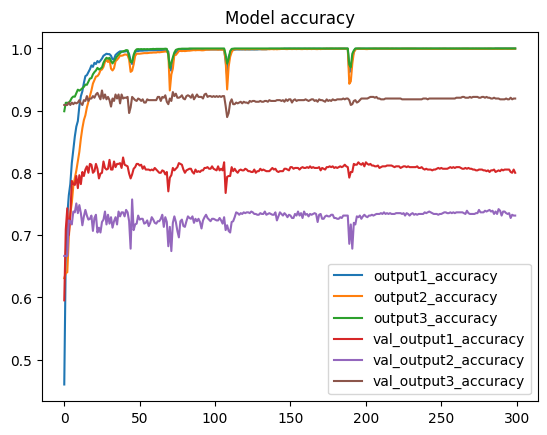

In [92]:
from keras.models import Model, load_model
import numpy as np

# Define the mapping between class indices and labels
class_mapping = {0: 'E', 1: 'P', 2: 'T'}

# Load the model
model = load_model('model_102.h5')

# Perform predictions on your test data
y_pred = model.predict(word_vectorstest)

# Use the test_labels dictionary for evaluation
score = model.evaluate(word_vectorstest, y_test_last, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

# Initialize a list to store predictions
y_pred_labels = []

# Convert class indices to labels and format the predictions
for i in range(len(y_pred[0])):
    output1_argmax = y_pred[0][i].argmax()
    output1_label = class_mapping[output1_argmax] if output1_argmax in class_mapping else ''

    output2_argmax = y_pred[1][i].argmax()
    output2_label = class_mapping[output2_argmax] if output2_argmax in class_mapping else ''

    output3_argmax = y_pred[2][i].argmax()
    output3_label = class_mapping[output3_argmax] if output3_argmax in class_mapping else ''

    # Combine the predicted labels
    predicted_labels = [label for label in [output1_label, output2_label, output3_label] if label != '']
    predicted_labels_str = ",".join(predicted_labels)

    y_pred_labels.append(f"{i + 1}::{predicted_labels_str}")

# Save predictions to a text file
with open('predictions.txt', 'w') as f:
    f.write("\n".join(y_pred_labels))

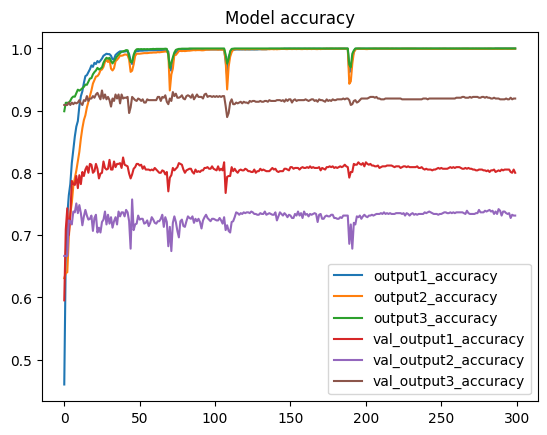

[[313  73  12]
 [ 57 340  15]
 [ 10  21 122]]


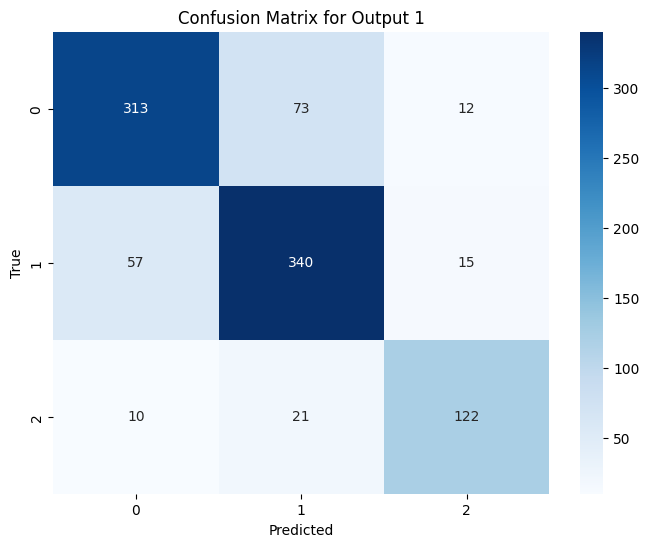

[[ 85  15   3  65]
 [ 13  54   9  38]
 [  3   5  40  17]
 [ 37  18  10 551]]


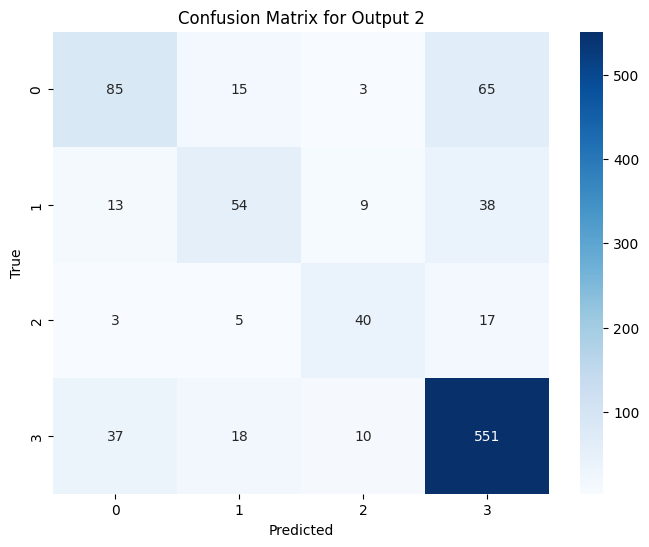

[[ 11   3   0  22]
 [  4   9   1  14]
 [  2   1   2   5]
 [ 11  16   1 861]]


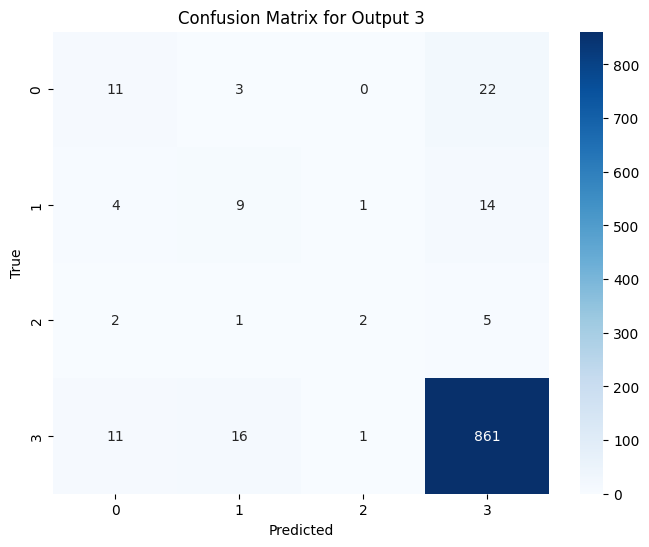

In [109]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.plot(history.history['output1_accuracy'], label='output1_accuracy')
plt.plot(history.history['output2_accuracy'], label='output2_accuracy')
plt.plot(history.history['output3_accuracy'], label='output3_accuracy')
plt.plot(history.history['val_output1_accuracy'], label='val_output1_accuracy')
plt.plot(history.history['val_output2_accuracy'], label='val_output2_accuracy')
plt.plot(history.history['val_output3_accuracy'], label='val_output3_accuracy')
plt.title('Model accuracy')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

for i in range(len(y_pred)):
    cm = confusion_matrix(y_test_last[i].argmax(axis=1), y_pred[i].argmax(axis=1))
    output_label = f'Output {i + 1}'
    # print(f'Confusion Matrix for {output_label}:')
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {output_label}')
    plt.show()